In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVR
import searchgrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# Description du jeu de données

## Chargement des données

In [2]:
data = pd.read_csv('./27-station-meteo-saint-cyprien.csv')
data.dtypes

data                                           object
id                                              int64
humidite                                        int64
direction_du_vecteur_de_vent_max                int64
pluie_intensite_max                           float64
pression                                        int64
direction_du_vecteur_vent_moyen                 int64
type_de_station                                object
pluie                                         float64
direction_du_vecteur_de_rafale_de_vent_max    float64
force_moyenne_du_vecteur_vent                   int64
force_rafale_max                                int64
temperature                                   float64
heure_de_paris                                 object
heure_utc                                      object
dtype: object

In [3]:
data.head()

,data,id,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_vent_moyen,type_de_station,pluie,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature,heure_de_paris,heure_utc
0,3726029001d000006d522000,27,58,9,0.0,100600,0,ISS,0.0,202.5,3,8,14.0,2019-09-06T06:45:00+02:00,2019-09-06T04:45:00+00:00
1,3726030fd9d800004d501800,27,59,8,0.0,100600,0,ISS,0.0,180.0,2,6,13.6,2019-09-06T07:45:00+02:00,2019-09-06T05:45:00+00:00
2,3726034fe1d000006d521800,27,58,9,0.0,100600,0,ISS,0.0,202.5,3,6,13.8,2019-09-06T08:15:00+02:00,2019-09-06T06:15:00+00:00
3,3726039005d000004d721800,27,58,9,0.0,100700,0,ISS,0.0,202.5,2,6,14.1,2019-09-06T08:45:00+02:00,2019-09-06T06:45:00+00:00
4,372603f04db000004d721800,27,54,9,0.0,100700,0,ISS,0.0,202.5,2,6,15.3,2019-09-06T09:30:00+02:00,2019-09-06T07:30:00+00:00


In [4]:
data.shape

(32947, 15)

In [5]:
data.describe()

,id,humidite,direction_du_vecteur_de_vent_max,pluie_intensite_max,pression,direction_du_vecteur_vent_moyen,pluie,direction_du_vecteur_de_rafale_de_vent_max,force_moyenne_du_vecteur_vent,force_rafale_max,temperature
count,32947.0,32947.000000,32947.000000,32947.000000,32947.000000,32947.000000,32947.0,32947.000000,32947.000000,32947.000000,32947.000000
mean,27.0,56.451634,7.374875,0.004104,99908.231402,25.453122,0.0,165.934683,2.471515,9.185176,15.942156
std,0.0,14.184005,3.755184,0.028353,907.562600,43.495457,0.0,84.491637,2.165187,6.016941,7.605225
min,27.0,0.000000,0.000000,0.000000,90000.000000,0.000000,0.0,0.000000,0.000000,0.000000,-50.000000
25%,27.0,48.000000,5.000000,0.000000,99500.000000,0.000000,0.0,112.500000,1.000000,5.000000,10.500000
50%,27.0,60.000000,8.000000,0.000000,99900.000000,0.000000,0.0,180.000000,2.000000,8.000000,15.000000
75%,27.0,67.000000,9.000000,0.000000,100400.000000,46.000000,0.0,202.500000,3.000000,13.000000,20.900000
max,27.0,82.000000,15.000000,0.200000,101800.000000,180.000000,0.0,337.500000,17.000000,51.000000,40.600000


# Prétraitement des données

on va retirer les attributs qui sont considérés comme inutiles, par exemple l'heure qui est en deux format différent, ou encore l'id ou le type de station qui sont tous identiques. De plus, on peut voir que la donnée pluie est totalement vide, les valeurs ne sont pas différentes de 0.

In [6]:
data = data.drop(['data','id','type_de_station','heure_de_paris','direction_du_vecteur_de_vent_max','pluie'],axis=1)

application de la fonction de prétraitement, qui va ordonner les données dans l'ordre chronologique, regrouper les valeurs de chaque attribut d'une journée en faisant la médiane (on remarque des valeurs aberrantes notamment dans l'attribut température, la médiane étant moins sensible à cela, on l'a choisie). Sachant qu'on cherche à prédire la valeur de la température du lendemain, à partir des données de la veille, on va ensuite décaller les valeurs de température d'un cran, de telle sorte que pour un jour J on ait toutes les informations (pression, vent..) mais que la température soit celle du jour J+1. Ainsi en appliquant le modèle celui-ci sera entrainé à prédire la valeur du lendemain à partir des données du jour.

In [7]:
def Pretraitement(data,dateDebut,dateAPredire) :
    data['heure_utc'] = pd.to_datetime(data['heure_utc']) # on met les données au format de date.
    data.sort_values(by=['heure_utc'], inplace=True, ascending=True) # on va trier nos données selon les dates, du plus vieux au plus récent
    data = data.set_index('heure_utc')
    data = data.resample('D').median() #groupement par jour en faisant la médiane des valeurs
    data['températureDécallée'] = data.temperature.shift(-1) #décalage des données de 1 de telle sorte que pour les données du jour J on ait une colonne températureDécallée qui correspond à la température du jour J+1
    data.dropna(inplace=True) #on retire le dernier jour de mesure car on ne connait pas la température du lendemain
    data = data.loc[dateDebut:dateAPredire]
    y = pd.DataFrame(data['températureDécallée'])
    df = data.drop(['températureDécallée'],axis = 1)
    x = df
    return x,y

# Premier Modèle en 1 dimension (Un jour J pris en compte)

In [8]:
df = pd.DataFrame(data)
df['heure_utc'] = pd.to_datetime(df['heure_utc'])
df.sort_values(by=['heure_utc'], inplace=True, ascending=True)
df.set_index('heure_utc', inplace = True)
a = df.groupby(df.index.date).median()
temp = pd.DataFrame(a.temperature, columns=['temperature'])
temp['y'] = temp.temperature.shift(-1) #decalage de 1 vers le haut
temp.head()

,temperature,y
2019-06-26,27.50,32.10
2019-06-27,32.10,27.45
2019-06-28,27.45,30.55
2019-06-29,30.55,25.30
2019-06-30,25.30,22.40


Text(0, 0.5, 'temperature du lendemain')

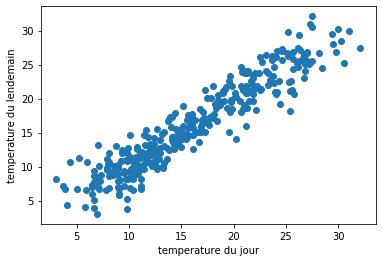

In [14]:
temp.dropna(inplace=True)
y = temp.iloc[:,1:].values
X = temp.iloc[:,0:1].values
plt.scatter(X,y)
plt.xlabel('temperature du jour')
plt.ylabel('temperature du lendemain')

In [15]:
xtrain = X[0:258]
xtest = X[258:]
ytrain = y[0:258]
ytest= y[258:]

In [16]:
regressor=SVR(kernel='linear')
regressor.fit(xtrain,ytrain)

/home/galapagos/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR(kernel='linear')

In [17]:
pred=regressor.predict(xtest)
print('nombre de donnée d''entrainement : ',xtrain.shape) 
print('R² = ',regressor.score(xtest,ytest))
print('RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

nombre de donnée dentrainement :  (258, 1)
R² =  0.7578395440510822
RMSE =  1.9691848745739422 °C


Text(0, 0.5, 'temperature du lendemain')

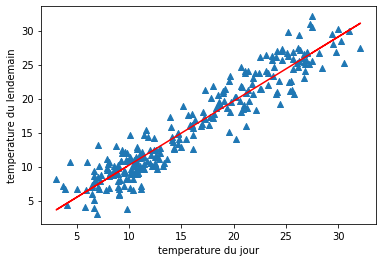

In [18]:
plt.scatter(xtrain,ytrain,marker = '^')
plt.plot(xtrain,regressor.predict(xtrain),'-r')
plt.xlabel('temperature du jour')
plt.ylabel('temperature du lendemain')

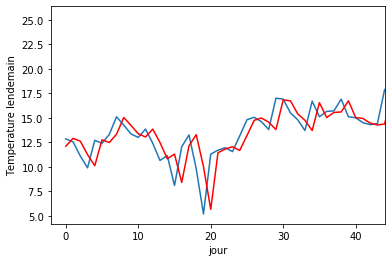

In [19]:
jour = np.arange(len(ytest))
plt.plot(jour,ytest)
plt.plot(jour,regressor.predict(xtest),'-r')
plt.xlabel('jour')
plt.ylabel('Temperature lendemain')
scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)# on visualise que la moitié des données
plt.show()


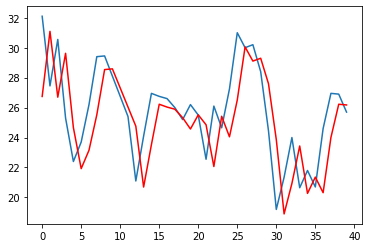

In [20]:
plt.plot(np.arange(40),ytrain[0:40])
plt.plot(np.arange(40),regressor.predict(xtrain[0:40]),'-r')
# en rouge la prediction
# en bleu la valeur attendu

In [21]:
jourTotal = np.arange(len(y))
plt.scatter(jourTotal[len(ytrain)],ytrain)
plt.scatter(jourTotal[len(ytrain):],ytest)
plt.plot(jourTotal,regressor.predict(X))

ValueError: x and y must be the same size

# Modèle pour plusieurs dimensions (jour J pris en compte)

In [153]:
data.shape

(32947, 9)

In [185]:
x, y = Pretraitement(data,"2019-06-26","2020-06-03")

In [186]:
x.dtypes

humidite                                      float64
pluie_intensite_max                           float64
pression                                      float64
direction_du_vecteur_vent_moyen               float64
direction_du_vecteur_de_rafale_de_vent_max    float64
force_moyenne_du_vecteur_vent                 float64
force_rafale_max                              float64
temperature                                   float64
dtype: object

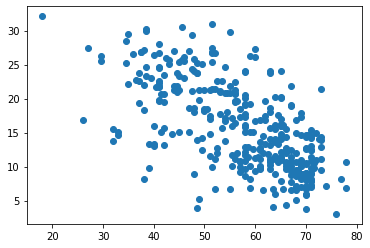

In [187]:
plt.scatter(x['humidite'],y['températureDécallée'])

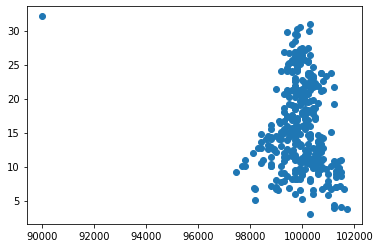

In [172]:
plt.scatter(x['pression'],y['températureDécallée'])

On se rend compte qu'il y a beaucoup d'attribut qui sont susceptible d'être correlées entre eux, on va donc chercher les attributs qui apportent le plus d'information pour ne garder que ceux la.

In [188]:
y = y.iloc[:,0:].values #on change nos dataFrames en tableaux de valeurs pour qu'elles soient manipulées par la fonction SVR()
x = x.iloc[:,0:].values


In [174]:
#normalisation des features car les valeurs ne sont pas dans la même unité, il est difficile de les comparer.
sc_X = StandardScaler() 
x = sc_X.fit_transform(x)

In [175]:
xtrain = x[0:272,:] #séparation en donnée d'entrainement et en donnée de test
xtest = x[272:,:]
ytrain = np.ravel(y[0:272,:])
ytest = np.ravel(y[272:,:])

In [176]:
estimator = SVR(kernel="linear")
selector = RFE(estimator)
selector = selector.fit(xtrain, ytrain)
rank = selector.ranking_ #on a alors les features les plus importants pour le modèle
indice = np.ravel(np.argwhere(rank == 1 ))

In [177]:
xtrain = xtrain[:,indice]
xtest = xtest[:,indice]

In [178]:
indice # on garde les attributs : humidité , pression, direction_du_vecteur_de_rafale_de_vent_max, température

array([0, 2, 3, 7])

In [179]:
regressor=SVR(kernel='rbf')
regressor.fit(xtrain,ytrain)
pred=regressor.predict(xtest)
print('nombre de donnée d''entrainement : ',xtrain.shape) 
print('R² = ',regressor.score(xtest,ytest))
print('RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

nombre de donnée dentrainement :  (272, 4)
R² =  0.7179942269328832
RMSE =  2.1254864115538616 °C


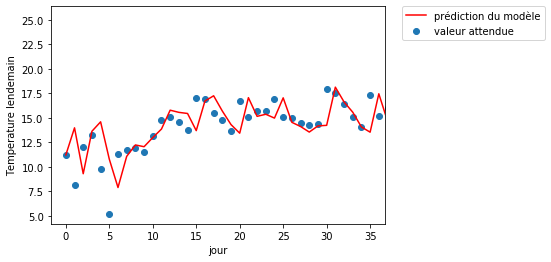

In [180]:
jour = np.arange(len(ytest))
plt.scatter(jour,ytest,label='valeur attendue')
plt.plot(jour,regressor.predict(xtest),'-r',label='prédiction du modèle')
plt.xlabel('jour')
plt.ylabel('Temperature lendemain')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.show()
# on visualise que la moitié des données

## Grid Search pour trouver un modèle plus précis

In [181]:
C = np.arange(1,10,0.5)
gamma = np.arange(1e-9, 1e-7,1e-8)
epsilon = np.arange(0.1,0.3,0.1)

In [182]:
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':C ,'gamma': gamma,'epsilon':epsilon}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(xtrain,ytrain)
clf.best_params_

{'C': 1.5, 'epsilon': 0.2, 'gamma': 1e-09, 'kernel': 'linear'}

In [183]:
regressorGridSearch=SVR(C= 1.5, epsilon = 0.2, gamma = 1e-09,kernel='linear')
regressorGridSearch.fit(xtrain,ytrain)
pred=regressorGridSearch.predict(xtest)
print('nombre de donnée d''entrainement : ',xtrain.shape) 
print('R² = ',regressorGridSearch.score(xtest,ytest))
print('RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

nombre de donnée dentrainement :  (272, 4)
R² =  0.7302388105171913
RMSE =  2.078830438831827 °C


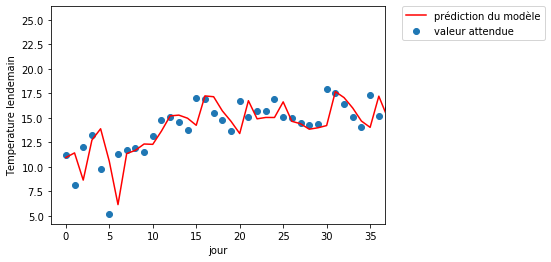

In [184]:
jour = np.arange(len(ytest))
plt.scatter(jour,ytest,label='valeur attendue')
plt.plot(jour,regressorGridSearch.predict(xtest),'-r',label='prédiction du modèle')
plt.xlabel('jour')
plt.ylabel('Temperature lendemain')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.show()
# on visualise que la moitié des données

# Prise en compte de plusieurs jours (Température J-... pour prédire Température J+1)

Dans cette partie, pour prédire la valeur de la température a J+1, on va prendre en compte les valeurs des températures, pression, 

In [132]:
def PriseEnCompteDeXJours(x,y,nbjours) :
     y = np.ravel(y.iloc[nbjours:,:].values) #on change nos dataFrames en tableaux de valeurs pour qu'elles soient manipulées par la fonction SVR()
     x = x.iloc[:,0:].values
     xnew = np.zeros((x.shape[0]-nbjours,x.shape[1]*(nbjours+1)))
     for i in range(nbjours,x.shape[0]) :
         xnew[i-nbjours] = np.ravel(x[i-nbjours:i+1,:])
     return xnew,y

In [46]:
def PriseEnCompteDeXJours(x,y,nbjours,features=[]) :
     y = np.ravel(y.iloc[nbjours:,:].values) #on change nos dataFrames en tableaux de valeurs pour qu'elles soient manipulées par la fonction SVR()
     x = x.iloc[:,0:].values
     sc_X = StandardScaler() 
     x = sc_X.fit_transform(x)
     xnew = np.zeros((x.shape[0]-nbjours,x.shape[1]+(nbjours*len(features))))
     for i in range(nbjours,x.shape[0]) :
         temp = np.ravel(x[i-nbjours:i,features])
         xnew[i-nbjours] = np.concatenate((temp, x[nbjours,:]), axis=None)
     return xnew, y

In [148]:
print('Prise en compte des températures')
for j in range(1,8) : 
    X,y = Pretraitement(data,"2019-06-26","2020-06-03")
    X = pd.DataFrame(X['temperature'])
    xnew, ynew = PriseEnCompteDeXJours(X,y,j)
    indice = round(0.8*len(xnew))
    xtrain = xnew[0:indice,:]
    ytrain = ynew[0:indice]
    xtest = xnew[indice:,:]
    ytest = ynew[indice:]
    regressor=SVR(kernel='linear')
    regressor.fit(xtrain,ytrain)
    pred=regressor.predict(xtest)
    print('J-',j,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

Prise en compte des températures
J- 1 len(xtrain):  274 RMSE =  2.027082188874238 °C
J- 2 len(xtrain):  273 RMSE =  1.998807588228589 °C
J- 3 len(xtrain):  272 RMSE =  1.9912563101063014 °C
J- 4 len(xtrain):  271 RMSE =  2.127995200399387 °C
J- 5 len(xtrain):  270 RMSE =  2.134428562923103 °C
J- 6 len(xtrain):  270 RMSE =  2.141932224246946 °C
J- 7 len(xtrain):  269 RMSE =  2.1460264010832155 °C


In [141]:
print('Prise en compte des pressions')
X, y = Pretraitement(data,"2019-06-26","2020-06-03")
X = pd.DataFrame(X['pression'])
for i in range(1,8) :
    Xnew, ynew = PriseEnCompteDeXJours(X,y,i)
    indice = round(0.8*len(Xnew))
    xtrain = Xnew[0:indice,:]
    ytrain = ynew[0:indice]
    xtest = Xnew[indice:,:]
    ytest = ynew[indice:]
    regressor=SVR(kernel='rbf')
    regressor.fit(xtrain,ytrain)
    pred=regressor.predict(xtest)
    print('J-',i,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C') 

Prise en compte des pressions
J- 1 len(xtrain):  274 RMSE =  5.36537296254958 °C
J- 2 len(xtrain):  273 RMSE =  5.707919847050298 °C
J- 3 len(xtrain):  272 RMSE =  5.739085041893218 °C
J- 4 len(xtrain):  271 RMSE =  5.887723757585986 °C
J- 5 len(xtrain):  270 RMSE =  6.051736813532714 °C
J- 6 len(xtrain):  270 RMSE =  6.08993402132695 °C
J- 7 len(xtrain):  269 RMSE =  6.190481360306818 °C


In [279]:
print('Prise en compte de l''humidité')
X, y = Pretraitement(data,"2019-06-26","2020-06-03")
X = pd.DataFrame(X['humidite'])
for i in range(1,8) :
    Xnew, ynew = PriseEnCompteDeXJours(X,y,i)
    indice = round(0.8*len(Xnew))
    xtrain = Xnew[0:indice,:]
    ytrain = ynew[0:indice]
    xtest = Xnew[indice:,:]
    ytest = ynew[indice:]
    regressor=SVR(kernel='rbf')
    regressor.fit(xtrain,ytrain)
    pred=regressor.predict(xtest)
    print('J-',i,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C') 

Prise en compte de lhumidité
J- 1 len(xtrain):  274 RMSE =  5.763854850741865 °C
J- 2 len(xtrain):  273 RMSE =  5.714569176392154 °C
J- 3 len(xtrain):  272 RMSE =  5.883868918263867 °C
J- 4 len(xtrain):  271 RMSE =  5.849797900146331 °C
J- 5 len(xtrain):  270 RMSE =  6.1585250132708955 °C
J- 6 len(xtrain):  270 RMSE =  6.12756936846157 °C
J- 7 len(xtrain):  269 RMSE =  6.053739287248263 °C


In [301]:
print('Prise en compte de l''direction_du_vecteur_de_rafale_de_vent_max')
X, y = Pretraitement(data,"2019-06-26","2020-06-03")
X = pd.DataFrame(X['direction_du_vecteur_de_rafale_de_vent_max'])
for i in range(1,8) :
    Xnew, ynew = PriseEnCompteDeXJours(X,y,i)
    indice = round(0.8*len(Xnew))
    xtrain = Xnew[0:indice,:]
    ytrain = ynew[0:indice]
    xtest = Xnew[indice:,:]
    ytest = ynew[indice:]
    regressor=SVR(kernel='rbf')
    regressor.fit(xtrain,ytrain)
    pred=regressor.predict(xtest)
    print('J-',i,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C') 

Prise en compte de ldirection_du_vecteur_de_rafale_de_vent_max
J- 1 len(xtrain):  274 RMSE =  5.24384793605522 °C
J- 2 len(xtrain):  273 RMSE =  5.278034393486227 °C
J- 3 len(xtrain):  272 RMSE =  5.295221902810117 °C
J- 4 len(xtrain):  271 RMSE =  5.347154273399021 °C
J- 5 len(xtrain):  270 RMSE =  5.399628936052811 °C
J- 6 len(xtrain):  270 RMSE =  5.457515699651288 °C
J- 7 len(xtrain):  269 RMSE =  5.475313492013118 °C


on voit donc que la meilleure prédiction que nous avons est la température prise pour 2 jours précédent

In [288]:
X, y = Pretraitement(data,"2019-06-26","2020-06-03")
X = pd.DataFrame(X[['humidite','pression','temperature','direction_du_vecteur_de_rafale_de_vent_max']]) #on selectionne les variables qui donnent le plus d'info
X.head()

,humidite,pression,temperature,direction_du_vecteur_de_rafale_de_vent_max
heure_utc,,,,
2019-06-26,18.0,90000.0,27.50,22.5
2019-06-27,27.0,100000.0,32.10,135.0
2019-06-28,45.5,99900.0,27.45,202.5
2019-06-29,48.5,99700.0,30.55,157.5
2019-06-30,56.0,100050.0,25.30,202.5


on prend en compte la température des deux jours précedent et température, pression, humidité, vent du jour J pour prédire le jour J+1

In [289]:
Xnew, ynew = PriseEnCompteDeXJours(X,y,2,[2])
indice = round(0.8*len(Xnew))
xtrain = Xnew[0:indice,:]
ytrain = ynew[0:indice]
xtest = Xnew[indice:,:]
ytest = ynew[indice:]
regressor=SVR(kernel='rbf')
regressor.fit(xtrain,ytrain)
pred=regressor.predict(xtest)
print('J-',2,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

J- 2 len(xtrain):  273 RMSE =  2.744764446408431 °C


selection des attributs les plus importants parmis tout ceux mis

In [294]:
estimator = SVR(kernel="linear")
selector = RFE(estimator)
selector = selector.fit(xtrain, ytrain)
rank = selector.ranking_ #on a alors les features les plus importants pour le modèle
indice = np.ravel(np.argwhere(rank == 1 ))

In [295]:
xtrain = xtrain[:,indice]
xtest = xtest[:,indice]

In [300]:
C = np.arange(1,10,0.1)
gamma = np.arange(1e-9, 1e-7,1e-8)
epsilon = np.arange(0.1,0.3,0.1)
len(epsilon),len(gamma),len(C)

(2, 10, 90)

In [297]:
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':C ,'gamma': gamma,'epsilon':epsilon}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(xtrain,ytrain)
clf.best_params_

{'C': 8, 'epsilon': 0.2, 'gamma': 1e-09, 'kernel': 'linear'}

In [298]:
regressorGridSearch=SVR(C= 9.0, epsilon = 0.2, gamma = 1e-09,kernel='linear')
regressorGridSearch.fit(xtrain,ytrain)
pred=regressorGridSearch.predict(xtest)
print('nombre de donnée d''entrainement : ',xtrain.shape) 
print('R² = ',regressorGridSearch.score(xtest,ytest))
print('RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

nombre de donnée dentrainement :  (273, 3)
R² =  0.5659582695363343
RMSE =  2.5292396621520337 °C


## 3 jours de température precedent jour J pour prédire celle du lendemain

In [190]:
X, y = Pretraitement(data,"2019-06-26","2020-06-03")
X = pd.DataFrame(X['temperature'])

In [191]:
Xnew, ynew = PriseEnCompteDeXJours(X,y,3)
indice = round(0.8*len(Xnew))
xtrain = Xnew[0:indice,:]
ytrain = ynew[0:indice]
xtest = Xnew[indice:,:]
ytest = ynew[indice:]
regressor=SVR(kernel='linear')
regressor.fit(xtrain,ytrain)
pred=regressor.predict(xtest)
print('J-',2,'len(xtrain): ',xtrain.shape[0],'RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C') 

J- 2 len(xtrain):  272 RMSE =  1.9912563101063014 °C


In [150]:
C = np.arange(1,10,0.5)
gamma = np.arange(1e-9, 1e-7,1e-8)
epsilon = np.arange(0.1,0.3,0.1)
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':C ,'gamma': gamma,'epsilon':epsilon}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(xtrain,ytrain)
clf.best_params_

{'C': 1.0, 'epsilon': 0.1, 'gamma': 1e-09, 'kernel': 'linear'}

In [151]:
regressorGridSearch=SVR(C= 1.0, epsilon = 0.1, gamma = 1e-09,kernel='linear')
regressorGridSearch.fit(xtrain,ytrain)
pred=regressorGridSearch.predict(xtest)
print('nombre de donnée d''entrainement : ',xtrain.shape) 
print('R² = ',regressorGridSearch.score(xtest,ytest))
print('RMSE = ', np.sqrt(mean_squared_error(ytest, pred)),'°C')

nombre de donnée dentrainement :  (272, 4)
R² =  0.7309668174031742
RMSE =  1.9912563101063014 °C


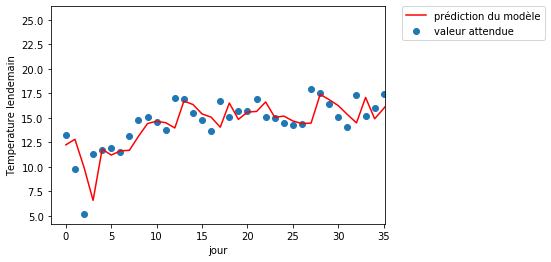

In [152]:
jour = np.arange(len(ytest))
plt.scatter(jour,ytest,label='valeur attendue')
plt.plot(jour,regressorGridSearch.predict(xtest),'-r',label='prédiction du modèle')
plt.xlabel('jour')
plt.ylabel('Temperature lendemain')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.show()